# Receding Horizon

This notebook is your playground to pull together techniques from the previous lessons! A solution here can be built from previous solutions (more or less) so we will offer no solution notebook this time.

Here's a suggested approach:

1. Load the colliders data
2. Discretize your search space into a grid or graph
3. Define a start and goal location
4. Find a coarse 2D plan from start to goal
5. Choose a location along that plan and discretize
   a local volume around that location (for example, you
   might try a 40x40 m area that is 10 m high discretized
   into 1m^3 voxels)
6. Define your goal in the local volume to a a node or voxel
   at the edge of the volume in the direction of the next
   waypoint in your coarse global plan.
7. Plan a path through your 3D grid or graph to that node
   or voxel at the edge of the local volume.  

We'll import some of the routines from previous exercises that you might find useful here.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Grid creation routine
from planning_utils import *
# Voxel map creation routine
#from voxmap import create_voxmap
# 2D A* planning routine (can you convert to 3D??)
#from planning import a_star
# Random sampling routine
#from sampling import Sampler
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = 20, 20

## Load Data

In [3]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)
data.shape

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


(3845, 6)

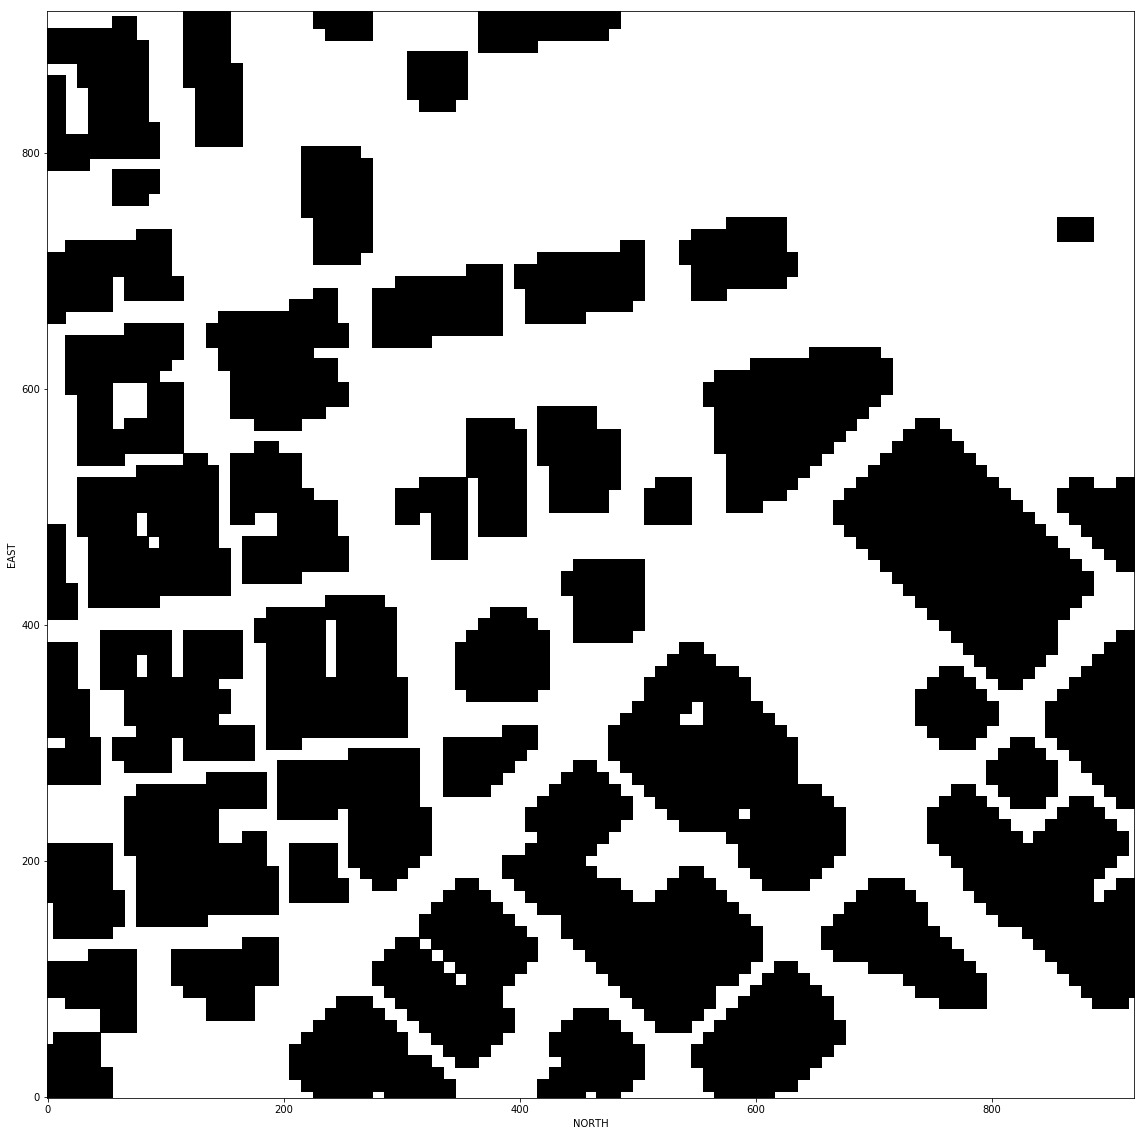

In [4]:
flight_altitude = 25
safety_distance = 5
grid, north_min, east_min = create_grid(data, flight_altitude, safety_distance)
visualize_grid(grid, data)

## Sample Data Points ##

In [15]:
sampler = Sampler(data, safety_distance, zmin = 10, zmax=flight_altitude)
nodes = sampler.sample(2000)
len(nodes)

417

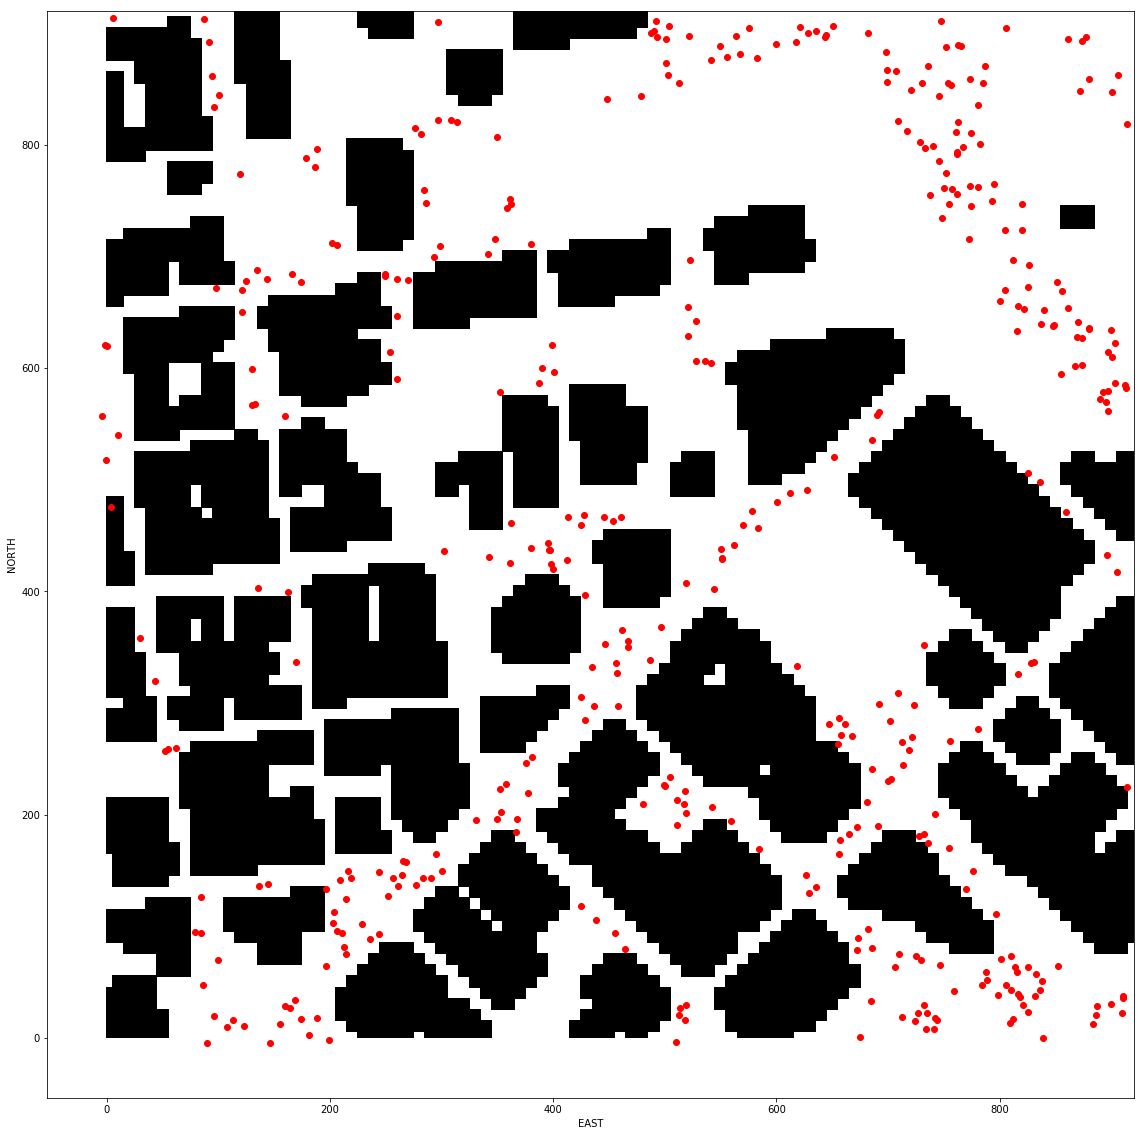

In [16]:
visualize_points(grid, data, nodes)

## Define Start / Goal ###

In [23]:
pts = np.array(nodes)

startIdx, finishIdx = np.random.randint(pts.shape[0], size=2)

start = tuple(pts[startIdx])
goal = tuple(pts[finishIdx])
start, goal

((-251.32991478603344, 348.31223596054633, 16.109176447783167),
 (464.9320410307992, 313.07098782458115, 20.947909659490357))

## Create Graph ##

In [18]:
g = create_graph(nodes, sampler.polygons, sampler.heights, 10)

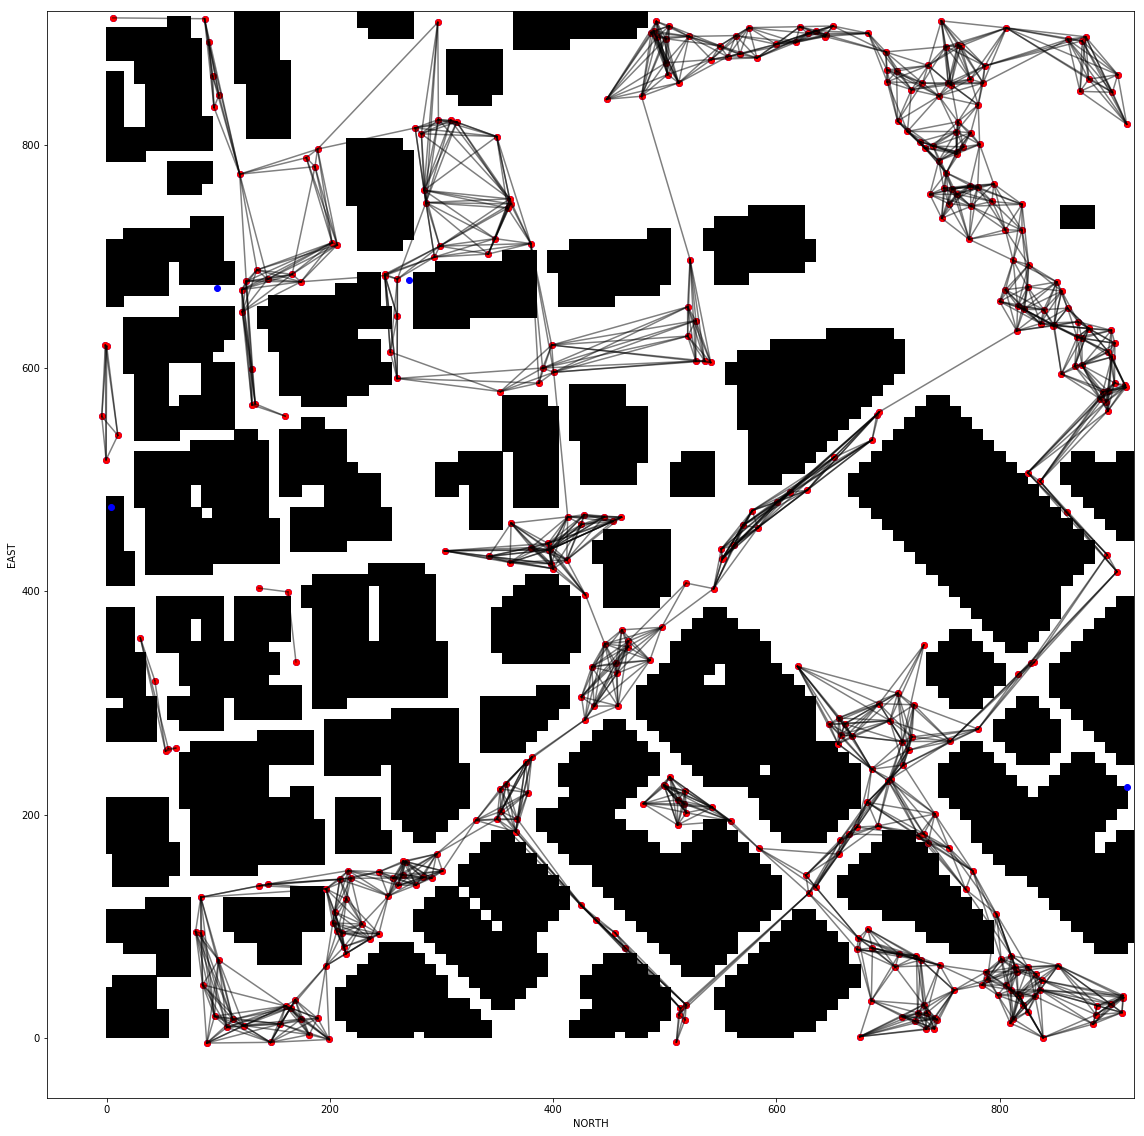

In [19]:
visualize_graph(grid, g, nodes, data)

In [24]:
path, cost = a_star_graph(g, heuristic, start, goal)

Found a path.


In [25]:
path, start, goal

([(-251.32991478603344, 348.31223596054633, 16.109176447783167),
  (-236.60415578857732, 371.3815150190146, 16.402667399075927),
  (-160.75275224751573, 336.66132193002295, 11.80912324349636),
  (-109.69881868458486, 302.77864534790217, 24.22742469281441),
  (-65.86762245762762, 274.54448991312665, 22.276647844372825),
  (-33.59017984872054, 341.5065871252564, 22.39337180356552),
  (25.699739928743156, 388.5980824151719, 14.602587600540087),
  (122.58447840707237, 457.2227972166726, 18.459687492380564),
  (196.15555798624467, 386.03051258919095, 22.860897479869728),
  (268.4086282757858, 453.1665083371007, 17.86241540932993),
  (284.71800110832675, 416.2112420346083, 11.712966107593882),
  (328.478273227752, 409.7189818532255, 11.602571164909605),
  (345.1562117103355, 377.0145867244489, 20.71102976475199),
  (386.4304940853381, 372.9516356286837, 15.396895170004932),
  (405.33176254478934, 333.4327030557412, 13.953196863024928),
  (450.64731301428304, 318.2004438676032, 17.24046750558

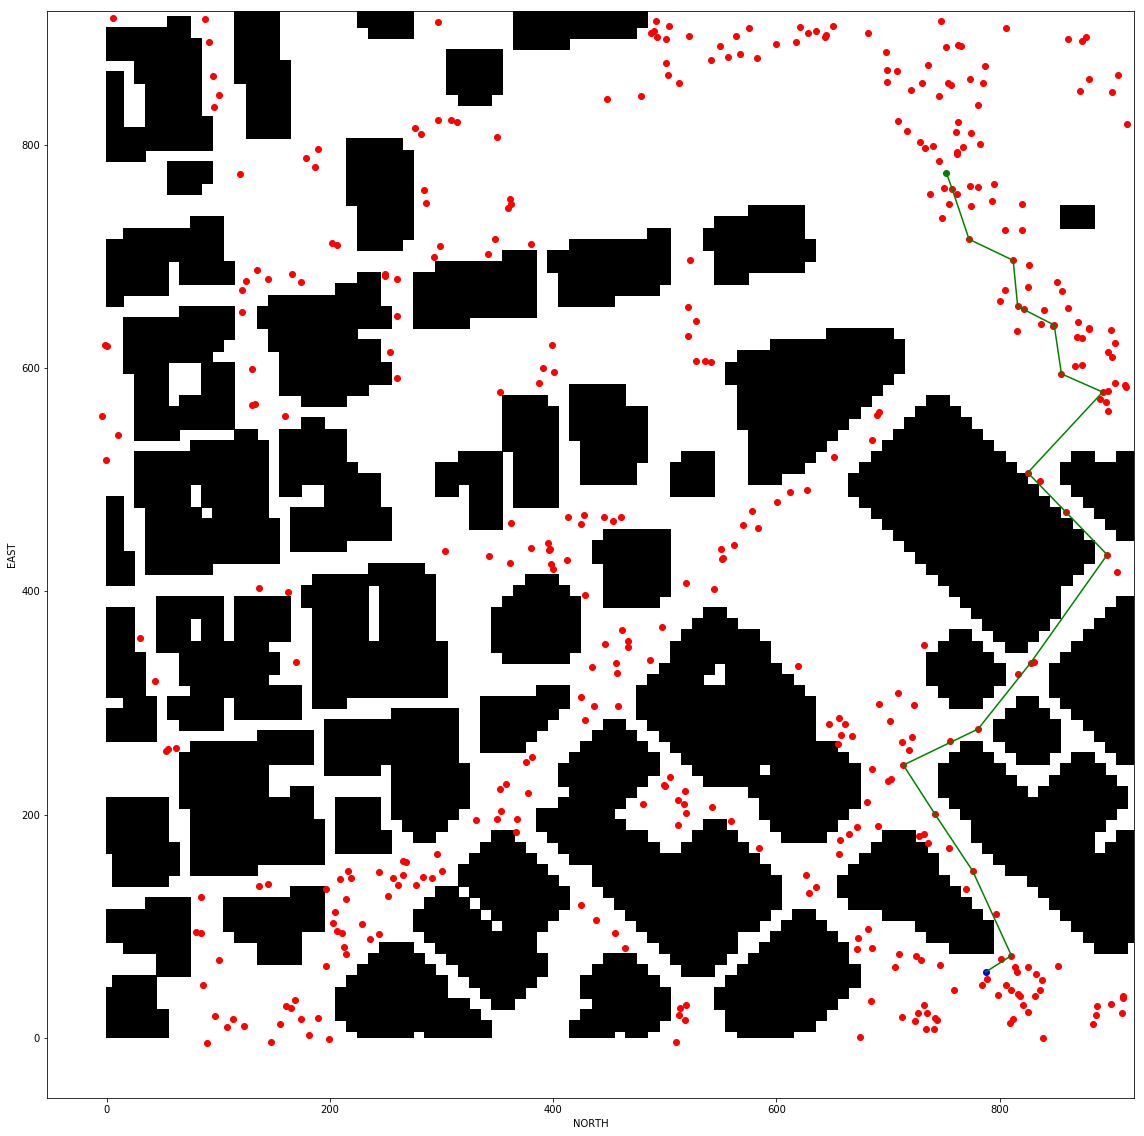

In [26]:
visualize_path(grid, g, data, path, start, goal)

## Local Planning ##

### Create Voxel Map ###

In [13]:
from shapely.geometry import Polygon, Point, LineString

In [14]:
local_horizon = (40, 40, 10)
voxel_size = 1

for p 

SyntaxError: invalid syntax (<ipython-input-14-61e6f306e561>, line 4)

In [ ]:
from sympy import Point3D, Line3D, Plane